In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score, roc_auc_score
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import GridSearchCV_scratch
import os
from datetime import datetime
import pickle
import numbers

In [3]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.left'] = False

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","dec_bound_experiment")
today_str = datetime.today().strftime("%Y%m%d")

# Simplified Decision Boundaries

## Create functions for experiment and plotting

In [5]:
# Functions for plotting dec boundaries of scratch estimators
def make_meshgrid(x, y, hx=.02, hy=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [16]:
def create_dec_boun_comparison(X, y, n_estimators=50, reg_params=[0.1,1,10,25,50,100], random_state=42, 
                                idx_feat1=None, idx_feat2=None, dset_name=None, feat_names=None):
    """Create decision boundary comparison for all four RF models for one dataset and one pair of features. Returns results as dict"""
    
    if not isinstance(X, pd.DataFrame):
        col_names = [f"X{i+1}" for i in range(X.shape[1])]
        X= pd.DataFrame(X, columns=col_names)
        y= pd.Series(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state)

    if (idx_feat1 is None) | (idx_feat2 is None):
    
        #Fit classifier for most imp feats
        rf = RandomForest(n_trees=n_estimators, random_state=random_state)
        rf.fit(X_train, y_train)

        # Get 1st and 2nd most important feature according to MDI
        most_imp_feats = np.argsort(rf.feature_importances_, axis=0)[-2:][::-1]
    else:
        most_imp_feats = [idx_feat1, idx_feat2]
        
    # get feature names
    if feat_names!=None:
        most_imp_feats_names = feat_names
    else:
        most_imp_feats_names = [X_train.columns[i] for i in most_imp_feats]

    # Create subset (only two features)
    X_small = X_train.iloc[:,most_imp_feats].copy()
    X_small_test = X_test.iloc[:,most_imp_feats].copy()

    #RF
    rf = RandomForest(n_trees=n_estimators, treetype='classification', random_state=random_state)
    rf.fit(X_small, y_train)
    y_pred = rf.predict(X_test.iloc[:,most_imp_feats])
    print("RF prediction complete")

    #HsRF
    grid = {"HS_lambda": reg_params}

    rf_HS = RandomForest(n_trees=n_estimators, treetype='classification', 
                            HShrinkage=True, random_state=random_state)
    grid_cv_HS = GridSearchCV_scratch(rf_HS, grid, X_small, y_train, 3, roc_auc_score, random_state=random_state)
    y_pred_HS = rf_HS.predict(X_test.iloc[:,most_imp_feats])
    print("hsRF prediction complete")

    #AugHSRF smSHAP
    rf_HSsmSH = RandomForest(n_trees=n_estimators, treetype='classification', oob=True, oob_SHAP=True,
                            HS_smSHAP=True, random_state=random_state)
    grid_cv_HSsmSH = GridSearchCV_scratch(rf_HSsmSH, grid, X_small, y_train, 3, roc_auc_score, random_state=random_state)
    y_pred_HSsmSH = rf_HSsmSH.predict(X_test.iloc[:,most_imp_feats])    
    print("AughsRF w. Smooth SHAP prediction complete")
    
    #AugHSRF MSE
    rf_HSmse= RandomForest(n_trees=n_estimators, treetype='classification', oob=True, oob_SHAP=True,
                            HS_nodewise_shrink_type="MSE_ratio", random_state=random_state)
    grid_cv_HSmse = GridSearchCV_scratch(rf_HSmse, grid, X_small, y_train, 3, roc_auc_score, random_state=random_state)
    y_pred_HSmse = rf_HSmse.predict(X_test.iloc[:,most_imp_feats])    
    print("AughsRF w. nodewise mse prediction complete")

    #AUC scores
    auc_rf = roc_auc_score(y_test, y_pred)
    auc_rf_HS = roc_auc_score(y_test, y_pred_HS)
    auc_rf_HSsmSH = roc_auc_score(y_test, y_pred_HSsmSH)
    auc_rf_HSmse = roc_auc_score(y_test, y_pred_HSmse)

    data = {
        "RF":{"model":rf,
            "auc":auc_rf},
        "HsRF":{"model":rf_HS,
            "auc":auc_rf_HS,
            "cv_results":grid_cv_HS},
        "AugHS_smSHAP":{"model":rf_HSsmSH,
            "auc":auc_rf_HSsmSH,
            "cv_results":grid_cv_HSsmSH},
        "AugHS_mse": {"model":rf_HSmse,
            "auc":auc_rf_HSmse,
            "cv_results":grid_cv_HSmse},
        "data":{"dset_name":dset_name,
                "most_imp_feats_names":most_imp_feats_names,
                "y_train":y_train,
                "X_small_train":X_small,
                "y_test": y_test,
                "X_small_test": X_small_test,
                "n_estimators":n_estimators,
                "reg_param":reg_params},
        "simulation_settings":{"lambdas":reg_params,
                               "random_state": random_state,
                               "idx_feat1":idx_feat1,
                               "idx_feat2":idx_feat2}}

    return data

In [7]:
def create_dec_boun_plot(data, hx=0.2, hy=0.2):
    """Create decision boundary comparison plot"""
    
    # Load datas
    X_small_test = data["data"]["X_small_test"]
    y_test = data["data"]["y_test"]
    dset_name = data["data"]["dset_name"]
    most_imp_feats_names = data["data"]["most_imp_feats_names"]
    rf = data["RF"]["model"]
    rf_HS = data["HsRF"]["model"]
    rf_HSsmSH = data["AugHS_smSHAP"]["model"]
    rf_HSmse = data["AugHS_mse"]["model"]
    auc = data["RF"]["auc"]
    auc_HS = data["HsRF"]["auc"]
    auc_HSsmSH = data["AugHS_smSHAP"]["auc"]
    auc_HSmse = data["AugHS_mse"]["auc"]
    model_names = ["RF", "HsRF", "AugHsRF smSHAP", "AugHsRF MSE"]
    
    #Create plot
    fig, axs = plt.subplots(1,4,figsize=(25,5))
       
    # Set-up grid for plotting.
    X0, X1 = X_small_test.iloc[:, 0], X_small_test.iloc[:, 1]
    xx, yy = make_meshgrid(X0, X1, hx=hx, hy=hy)

    # Scratch
    plot_contours(axs[0], rf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
    scatter = axs[0].scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    axs[0].set_ylabel(most_imp_feats_names[1])
    axs[0].set_xlabel(most_imp_feats_names[0])
    axs[0].set_title(f"{model_names[0]} (AUC {np.round(auc,3)})")
    axs[0].legend(*scatter.legend_elements());
    print("plot RF complete")

    # Scratch with HS
    plot_contours(axs[1], rf_HS, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
    scatter = axs[1].scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    axs[1].set_ylabel(most_imp_feats_names[1])
    axs[1].set_xlabel(most_imp_feats_names[0])
    axs[1].set_title(f"{model_names[1]} (AUC {np.round(auc_HS,3)})");
    axs[1].legend(*scatter.legend_elements());
    print("plot hsRF complete")

    # Scratch with HS smooth SHAP
    plot_contours(axs[2], rf_HSsmSH, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
    scatter = axs[2].scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    axs[2].set_ylabel(most_imp_feats_names[1])
    axs[2].set_xlabel(most_imp_feats_names[0])
    axs[2].set_title(f"{model_names[2]} (AUC {np.round(auc_HSsmSH,3)})")
    axs[2].legend(*scatter.legend_elements());
    print("plot hsRF w. Smooth SHAP complete")
    
    # Scratch with HS nodewise MSE
    plot_contours(axs[3], rf_HSmse, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
    scatter = axs[3].scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    axs[3].set_ylabel(most_imp_feats_names[1])
    axs[3].set_xlabel(most_imp_feats_names[0])
    axs[3].set_title(f"{model_names[3]} (AUC {np.round(auc_HSmse,3)})")
    axs[3].legend(*scatter.legend_elements());
    print("plot hsRF w. nodewise MSE complete")
    
    plt.suptitle(f"Titanic", fontsize=14);
    plt.show()  
    
    return fig, axs

## Titanic

### Load and clean data

In [36]:
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)

X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")

### Create decision boundary plot PClass and PID

In [37]:
# Pclass and PID
titanic_res1 = create_dec_boun_comparison(X, y, n_estimators=50, random_state=42, idx_feat1=1, idx_feat2=3, dset_name="titanic")

RF prediction complete
hsRF prediction complete
AughsRF w. Smooth SHAP prediction complete
AughsRF w. nodewise mse prediction complete


In [39]:
# Store results
with open(f'{data_path}/titanic_decbound_pclass_pid.pickle', 'wb') as handle:
    pickle.dump(titanic_res1, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot RF complete
plot hsRF complete
plot hsRF w. Smooth SHAP complete
plot hsRF w. nodewise MSE complete


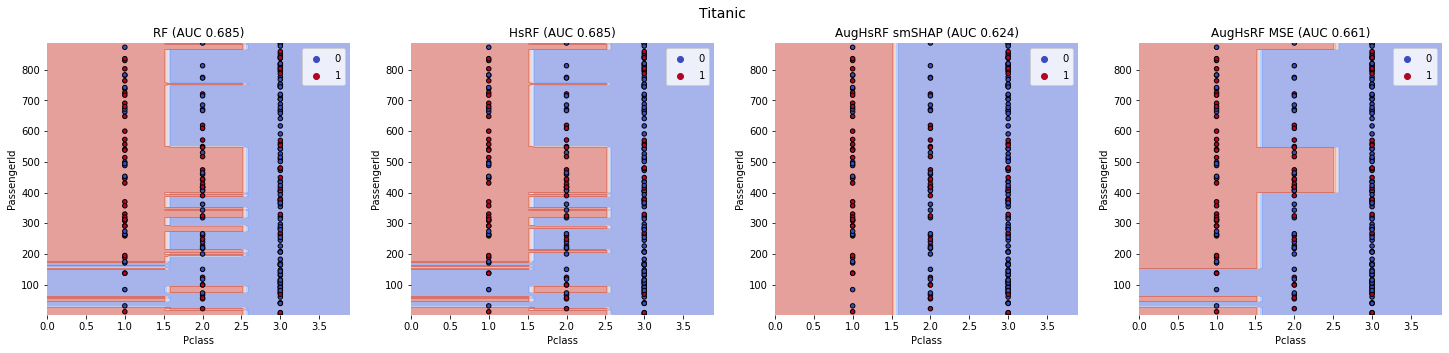

In [38]:
# Create plot
fig, axs = create_dec_boun_plot(titanic_res1, hx=0.1, hy=1)

- The original RF model reaches best AUC score, but also shows most fragmented decision boundaries
- hsRF smoothes the decision boundaries best, but performs slightly worse 
- hsRF Smooth SHAP "over-smoothes" the decision boundaries. Too high bias
- hsRF nodewise MSE also smoothed decision boundaries, but not as much as HS

In [40]:
# Save figure and data
fig.savefig(f"{data_path}/titanic_decbound_pclass_pid.png")

In [41]:
print("Lambda hsRF:", titanic_res1["HsRF"]["model"].HS_lambda)
print("Lambda hsRFsmSH:", titanic_res1["AugHS_smSHAP"]["model"].HS_lambda)
print("Coefficients hsRFsmSH:", titanic_res1["AugHS_smSHAP"]["model"].smSHAP_coefs)
print("Lambda hsRRmse:", titanic_res1["AugHS_mse"]["model"].HS_lambda)

Lambda hsRF: 1
Lambda hsRFsmSH: 100
Coefficients hsRFsmSH: [0.986847590721513, 0.3467667855161791]
Lambda hsRRmse: 10


### Create decision boundary plot Sex and PID

In [22]:
# Sex and PID
titanic_res2 = create_dec_boun_comparison(X, y, n_estimators=50, random_state=42, idx_feat1=2, idx_feat2=3, dset_name="titanic")

RF prediction complete
hsRF prediction complete
AughsRF w. Smooth SHAP prediction complete
AughsRF w. nodewise mse prediction complete


In [23]:
# Store results
with open(f'{data_path}/titanic_decbound_sex_pid.pickle', 'wb') as handle:
    pickle.dump(titanic_res2, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot RF complete
plot hsRF complete
plot hsRF w. Smooth SHAP complete
plot hsRF w. nodewise MSE complete


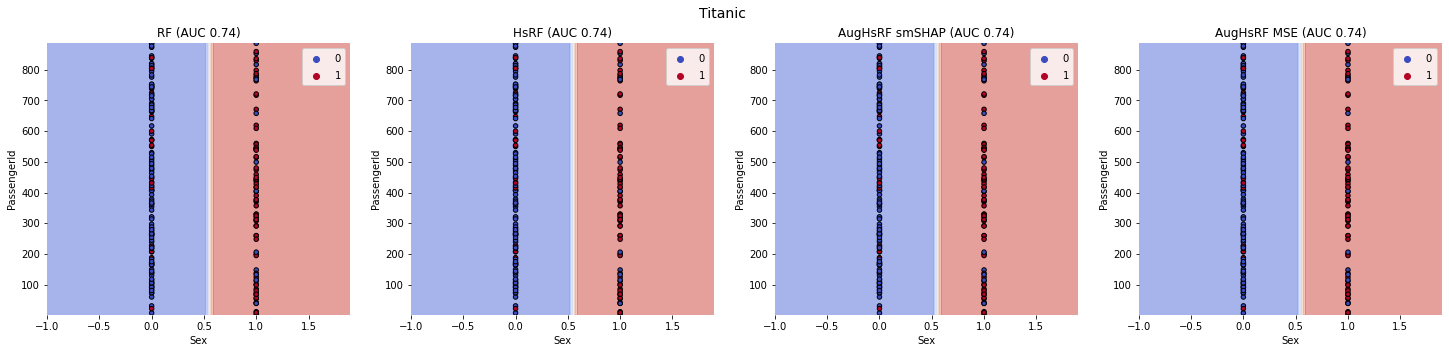

In [24]:
# Create plot
fig, axs = create_dec_boun_plot(titanic_res2, hx=0.1, hy=1)

- Suprisingly the results are identical for all models
- Even the original RF does not consider Passenger ID as a relevant feature

In [25]:
# Save figure and data
fig.savefig(f"{data_path}/titanic_decbound_sex_pid.png")

In [26]:
print("Lambda hsRF:", titanic_res2["HsRF"]["model"].HS_lambda)
print("Lambda hsRFsmSH:", titanic_res2["AugHS_smSHAP"]["model"].HS_lambda)
print("Coefficients hsRFsmSH:", titanic_res2["AugHS_smSHAP"]["model"].smSHAP_coefs)
print("Lambda hsRRmse:", titanic_res2["AugHS_mse"]["model"].HS_lambda)

Lambda hsRF: 0.1
Lambda hsRFsmSH: 0.1
Coefficients hsRFsmSH: [1.0081258575025807, 0.06168113917993158]
Lambda hsRRmse: 1


### Create decision boundary plot Age and PID

In [27]:
# Age and PID
titanic_res3 = create_dec_boun_comparison(X, y, n_estimators=50, random_state=42, idx_feat1=0, idx_feat2=3, dset_name="titanic")

RF prediction complete
hsRF prediction complete
AughsRF w. Smooth SHAP prediction complete
AughsRF w. nodewise mse prediction complete


In [28]:
# Store results
with open(f'{data_path}/titanic_decbound_age_pid.pickle', 'wb') as handle:
    pickle.dump(titanic_res3, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot RF complete
plot hsRF complete
plot hsRF w. Smooth SHAP complete
plot hsRF w. nodewise MSE complete


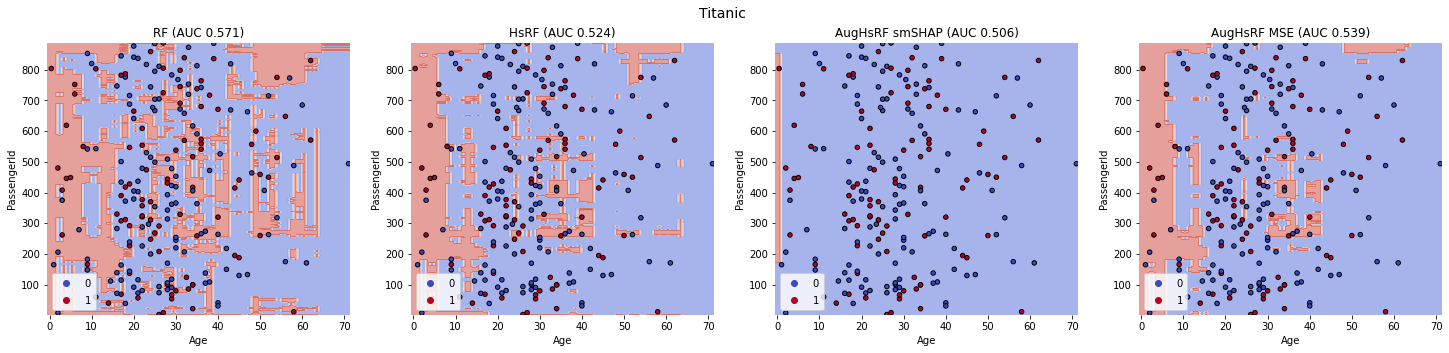

In [29]:
# Create plot
fig, axs = create_dec_boun_plot(titanic_res3, hx=1, hy=1)

- Original RF model DB rather unstable, but with highest AUC test score
- hsRF model still not very smooth, and worse than RF
- Smooth SHAP RF fails to draw a decision boundary -> high bias (always predict 0) and lowest AUC
- nodewise MSE RF shows most stable decision boundary which is mostly independent from Passenger ID and solely depends on age (prediction for age 0-10=1 "survided", rest "0"). Still AUC test score not as high as RF or hsRF

In [30]:
# Save figure and data
fig.savefig(f"{data_path}/titanic_decbound_age_pid.png")

In [31]:
print("Lambda hsRF:", titanic_res3["HsRF"]["model"].HS_lambda)
print("Lambda hsRFsmSH:", titanic_res3["AugHS_smSHAP"]["model"].HS_lambda)
print("Coefficients hsRFsmSH:", titanic_res3["AugHS_smSHAP"]["model"].smSHAP_coefs)
print("Lambda hsRRmse:", titanic_res3["AugHS_mse"]["model"].HS_lambda)

Lambda hsRF: 50
Lambda hsRFsmSH: 1
Coefficients hsRFsmSH: [0.19684588976020453, 0.007359230274975662]
Lambda hsRRmse: 50


## Strobl power case

### Simulate data

In [8]:
def simulate_data_strobl(n=120, # number of rows in data
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
    """Simulate Strobl dataset"""
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n))
    x2 = random_state.randint(1, 3, size=(n))
    x3 = random_state.randint(1, 5, size=(n))
    x4 = random_state.randint(1, 11, size=(n))
    x5 = random_state.randint(1, 21, size=(n))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [9]:
# Simulate data
X_power, y_power = simulate_data_strobl(n=120, relevance=0.15)

### Create decision boundary plot X1, X2

In [17]:
# X1 and X2
strobl_res1 = create_dec_boun_comparison(X_power, y_power, n_estimators=50, random_state=42, 
                                         idx_feat1=0, idx_feat2=1, dset_name="strobl",
                                         feat_names=["X1", "X2"])

RF prediction complete
hsRF prediction complete
AughsRF w. Smooth SHAP prediction complete
AughsRF w. nodewise mse prediction complete


In [ ]:
# Store results
with open(f'{data_path}/strobl_decbound_x1_x2.pickle', 'wb') as handle:
    pickle.dump(strobl_res1, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot RF complete
plot hsRF complete
plot hsRF w. Smooth SHAP complete
plot hsRF w. nodewise MSE complete


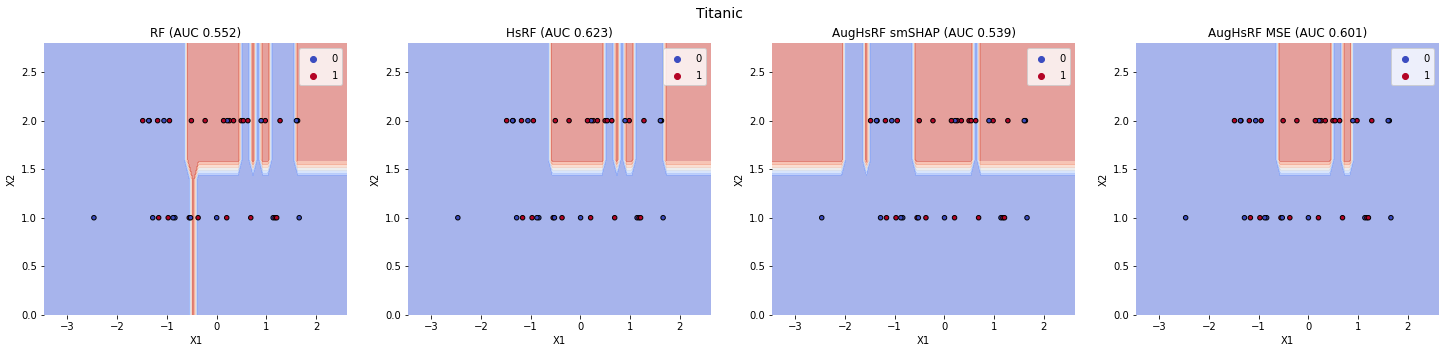

In [18]:
# Create plot
fig, axs = create_dec_boun_plot(strobl_res1, hx=0.1, hy=0.2)

- 

In [19]:
# Save figure and data
fig.savefig(f"{data_path}/strobl_decbound_x1_x2.png")

In [20]:
print("Lambda hsRF:", strobl_res1["HsRF"]["model"].HS_lambda)
print("Lambda hsRFsmSH:", strobl_res1["AugHS_smSHAP"]["model"].HS_lambda)
print("Coefficients hsRFsmSH:", np.round(strobl_res1["AugHS_smSHAP"]["model"].smSHAP_coefs,2))
print("Lambda hsRRmse:", strobl_res1["AugHS_mse"]["model"].HS_lambda)

Lambda hsRF: 50
Lambda hsRFsmSH: 0.1
Coefficients hsRFsmSH: [0.43 0.96]
Lambda hsRRmse: 50


### Create decision boundary plot X3, X2

In [21]:
# X3 and X2
strobl_res2 = create_dec_boun_comparison(X_power, y_power, n_estimators=50, random_state=42, 
                                         idx_feat1=2, idx_feat2=1, dset_name="strobl",
                                         feat_names=["X3", "X2"])

RF prediction complete
hsRF prediction complete
AughsRF w. Smooth SHAP prediction complete
AughsRF w. nodewise mse prediction complete


In [22]:
# Store results
with open(f'{data_path}/strobl_decbound_x3_x2.pickle', 'wb') as handle:
    pickle.dump(strobl_res2, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot RF complete
plot hsRF complete
plot hsRF w. Smooth SHAP complete
plot hsRF w. nodewise MSE complete


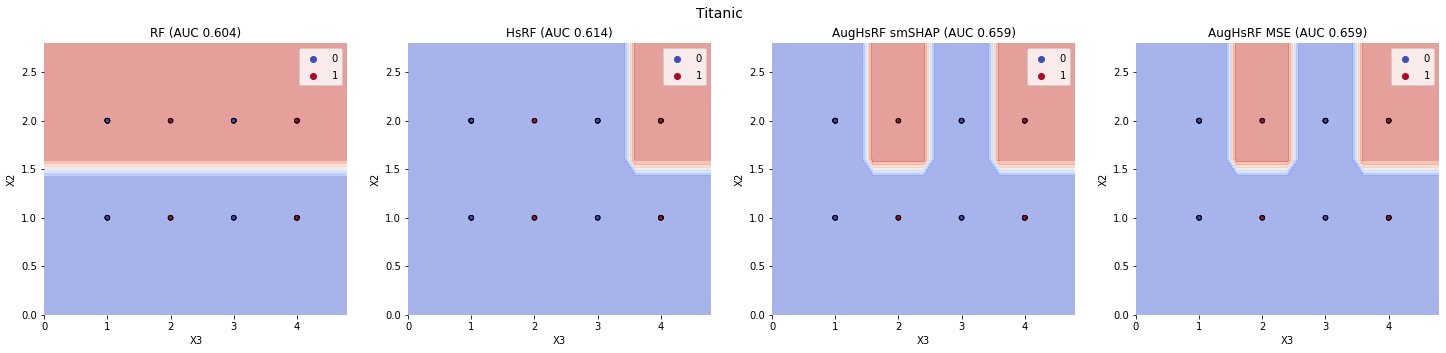

In [23]:
# Create plot
fig, axs = create_dec_boun_plot(strobl_res2, hx=0.2, hy=0.2)

- 

In [24]:
# Save figure and data
fig.savefig(f"{data_path}/strobl_decbound_x3_x2.png")

In [25]:
print("Lambda hsRF:", strobl_res2["HsRF"]["model"].HS_lambda)
print("Lambda hsRFsmSH:", strobl_res2["AugHS_smSHAP"]["model"].HS_lambda)
print("Coefficients hsRFsmSH:", np.round(strobl_res2["AugHS_smSHAP"]["model"].smSHAP_coefs,2))
print("Lambda hsRRmse:", strobl_res2["AugHS_mse"]["model"].HS_lambda)

Lambda hsRF: 100
Lambda hsRFsmSH: 50
Coefficients hsRFsmSH: [0.84 0.96]
Lambda hsRRmse: 50


### Create decision boundary plot X4, X2

In [26]:
# X4 and X2
strobl_res3 = create_dec_boun_comparison(X_power, y_power, n_estimators=50, random_state=42, 
                                         idx_feat1=3, idx_feat2=1, dset_name="strobl",
                                         feat_names=["X4", "X2"])

RF prediction complete
hsRF prediction complete
AughsRF w. Smooth SHAP prediction complete
AughsRF w. nodewise mse prediction complete


In [27]:
# Store results
with open(f'{data_path}/strobl_decbound_x4_x2.pickle', 'wb') as handle:
    pickle.dump(strobl_res3, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot RF complete
plot hsRF complete
plot hsRF w. Smooth SHAP complete
plot hsRF w. nodewise MSE complete


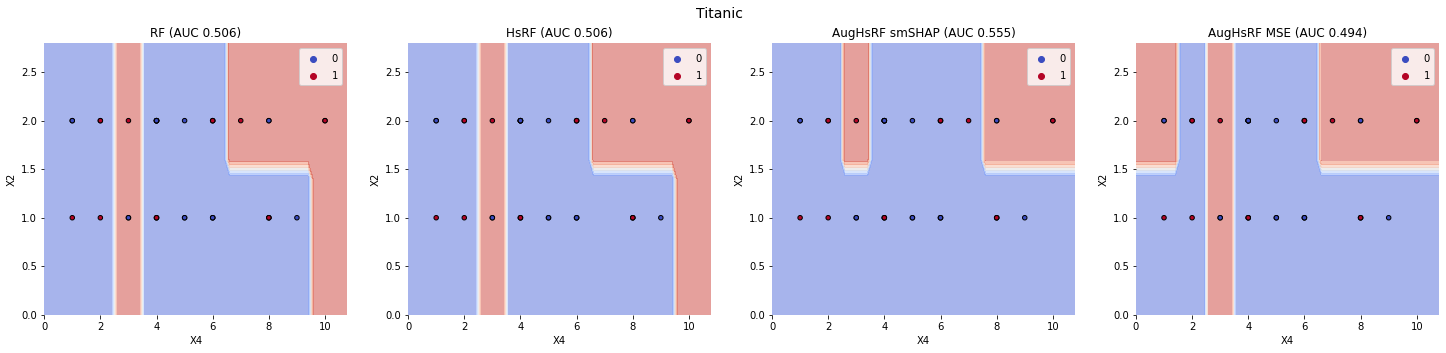

In [28]:
# Create plot
fig, axs = create_dec_boun_plot(strobl_res3, hx=0.2, hy=0.2)

- 

In [29]:
# Save figure and data
fig.savefig(f"{data_path}/strobl_decbound_x4_x2.png")

In [30]:
print("Lambda hsRF:", strobl_res3["HsRF"]["model"].HS_lambda)
print("Lambda hsRFsmSH:", strobl_res3["AugHS_smSHAP"]["model"].HS_lambda)
print("Coefficients hsRFsmSH:", np.round(strobl_res3["AugHS_smSHAP"]["model"].smSHAP_coefs,2))
print("Lambda hsRRmse:", strobl_res3["AugHS_mse"]["model"].HS_lambda)

Lambda hsRF: 0.1
Lambda hsRFsmSH: 50
Coefficients hsRFsmSH: [0.76 0.96]
Lambda hsRRmse: 0.1


### Create decision boundary plot X5, X2

In [31]:
# X5 and X2
strobl_res4 = create_dec_boun_comparison(X_power, y_power, n_estimators=50, random_state=42, 
                                         idx_feat1=4, idx_feat2=1, dset_name="strobl",
                                         feat_names=["X5", "X2"])

RF prediction complete
hsRF prediction complete
AughsRF w. Smooth SHAP prediction complete
AughsRF w. nodewise mse prediction complete


In [32]:
# Store results
with open(f'{data_path}/strobl_decbound_x5_x2.pickle', 'wb') as handle:
    pickle.dump(strobl_res4, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot RF complete
plot hsRF complete
plot hsRF w. Smooth SHAP complete
plot hsRF w. nodewise MSE complete


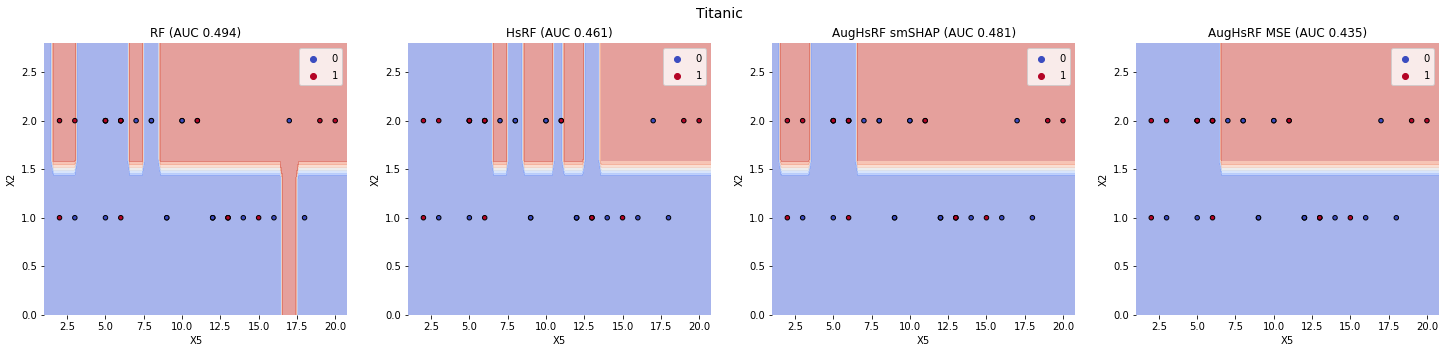

In [33]:
# Create plot
fig, axs = create_dec_boun_plot(strobl_res4, hx=0.2, hy=0.2)

- 

In [34]:
# Save figure and data
fig.savefig(f"{data_path}/strobl_decbound_x5_x2.png")

In [35]:
print("Lambda hsRF:", strobl_res4["HsRF"]["model"].HS_lambda)
print("Lambda hsRFsmSH:", strobl_res4["AugHS_smSHAP"]["model"].HS_lambda)
print("Coefficients hsRFsmSH:", np.round(strobl_res4["AugHS_smSHAP"]["model"].smSHAP_coefs,2))
print("Lambda hsRRmse:", strobl_res4["AugHS_mse"]["model"].HS_lambda)

Lambda hsRF: 50
Lambda hsRFsmSH: 0.1
Coefficients hsRFsmSH: [0.59 0.97]
Lambda hsRRmse: 50
